In [2]:
import pandas as pd

df = pd.read_json('FA-KSA_recording.json')

In [4]:
features = ['pitr','alt','clock','gs','heading','nav_qnh','nic_baro','vertRate','vertRate_geom','mach','heading_magnetic','nav_heading','nav_altitude','pressure']

position = ['alt'] #lat, lon

kinematic = ['gs'] # heading

operation = ['hexid','squawk']

data_for_iForest = position + kinematic

df = df.dropna(subset=data_for_iForest)

In [16]:
import numpy as np
df['anomaly'] = np.where(df['gs'] > df['alt'] * 2/225 + 310, -1, df['anomaly'])  # y2 = 2/225x + 310
df['anomaly'] = np.where(df['gs'] < df['alt'] * 31/4500 + 65, -1, df['anomaly']) # y1 = 31/4500 + 65
df['anomaly_scores'] = np.where(df['gs'] > df['alt'] * 2/225 + 310, 1, df['anomaly_scores'])
df['anomaly_scores'] = np.where(df['gs'] < df['alt'] * 31/4500 + 65, 1, df['anomaly_scores'])

In [18]:
def calc_true_course(true_heading, wind_direction, wind_speed, true_airspeed):
    # Convert degrees to radians
    heading_rad = math.radians(true_heading)
    wind_dir_rad = math.radians(wind_direction)
    
    # Calculate wind correction angle
    wind_track_angle = wind_dir_rad - math.pi  # Convert wind direction FROM to TO
    
    # Cross wind component
    cross_wind = wind_speed * math.sin(wind_track_angle - heading_rad)
    
    # Calculate wind correction angle
    wca = math.degrees(math.asin(cross_wind / true_airspeed))
    
    # Calculate true course
    true_course = true_heading + wca
    
    # Normalize to 0-360 degrees
    true_course = (true_course + 360) % 360
    
    return true_course, wca

In [20]:
true_course, wca = calc_true_course(df[heading], df[wind_speed], df[wind_speed], df[speed_tas])
gs_calc = np.sqrt(df[speed_tas]**2 + df[wind_speed]**2 - (2*df[speed_tas]*df[wind_speed]*np.cos(true_course) - df[wind_dir] + wca))

NameError: name 'heading' is not defined

# Scikit-Learn

In [10]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators  = 100,
    max_samples   = 100,
    contamination = 0.0001,
    max_features  = 1.0,
    bootstrap     = False,
    n_jobs        = -1,
    random_state  = 12,
    verbose       = 1,
    warm_start    = False)


iso_forest.fit(df[data_for_iForest])

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


IsolationForest(contamination=0.0001, max_samples=100, n_jobs=-1,
                random_state=12, verbose=1)

In [12]:
df['anomaly_scores'] = iso_forest.decision_function(df[data_for_iForest])

In [14]:
df['anomaly'] = iso_forest.predict(df[data_for_iForest])

In [234]:
df['anomaly'] = np.where(df['gs'] > df['alt'] * 2/225 + 310, -1, df['anomaly'])  # y2 = 2/225x + 310
df['anomaly'] = np.where(df['gs'] < df['alt'] * 31/4500 + 65, -1, df['anomaly']) # y1 = 31/4500 + 65
df['anomaly_scores'] = np.where(df['gs'] > df['alt'] * 2/225 + 310, 1, df['anomaly_scores'])
df['anomaly_scores'] = np.where(df['gs'] < df['alt'] * 31/4500 + 65, 1, df['anomaly_scores'])

In [236]:
df.loc[:,['alt','gs','vertRate','anomaly_scores','anomaly']]

,alt,gs,vertRate,anomaly_scores,anomaly
0,38975.0,495.0,0.0,0.197230,1
1,36000.0,406.0,0.0,0.242937,1
2,25525.0,426.0,1600.0,0.179922,1
3,350.0,157.0,-736.0,0.042960,1
4,36000.0,407.0,0.0,0.243325,1
...,...,...,...,...,...
39087,8175.0,284.0,0.0,0.136065,1
39088,39000.0,548.0,0.0,0.173631,1
39089,33000.0,460.0,0.0,0.229333,1
39090,7925.0,289.0,-1792.0,0.133522,1


In [238]:
import seaborn as sns
import matplotlib.pyplot as plt
add_line = True
line_function = None

def outlier_plot(data, outlier_method_name, x_var, y_var, 
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):
    
    print(f'Outlier Method: {outlier_method_name}')
    
    method = f'{outlier_method_name}_anomaly'
    
    print(f"Number of anomalous values {len(data[data['anomaly']==-1])}")
    print(f"Number of non anomalous values  {len(data[data['anomaly']== 1])}")
    print(f'Total Number of Values: {len(data)}')
    
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    if add_line:
        
        # If no line function provided, do linear regression
        from sklearn.linear_model import LinearRegression
        import numpy as np
        
        def line_function(x):
            x = np.array(x).reshape(-1, 1)
            y = data[y_var].values.reshape(-1, 1)
            reg = LinearRegression().fit(data[x_var].values.reshape(-1, 1), y)
            return reg.predict(x)
        
        # Add line to both plots
        for ax in g.axes.flat:
            #ax.plot([0,45000], [65,375], 'r-', label='Fitted Line')  # y1 = 31/4500 + 65
            #ax.plot([0,45000], [310,710], 'r-', label='Fitted Line') # y2 = 2/225x + 310
            ax.plot( [65,375],[0,45000], 'r-', label='Fitted Line')  # y1 = 31/4500 + 65
            ax.plot( [310,710],[0,45000], 'r-', label='Fitted Line') # y2 = 2/225x + 310
            ax.legend()
    
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anomaly']==  1])} points")
    return g

In [240]:
#outlier_plot(df,"Latitude vs Longitude", "lat","lon", [0,40],[20,80])

Outlier Method: Altitude vs Ground Speed
Number of anomalous values 4
Number of non anomalous values  33580
Total Number of Values: 33584


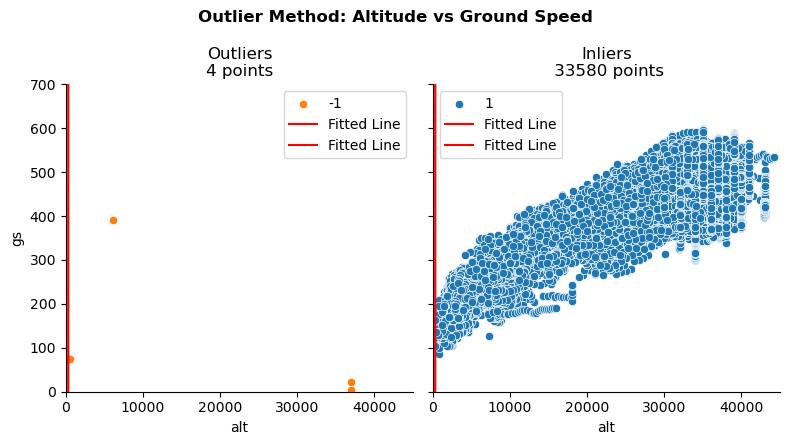

In [242]:
outlier_plot(df,"Altitude vs Ground Speed", "alt","gs", [0,45000],[0,700])

Outlier Method: Altitude vs Ground Speed
Number of anomalous values 4
Number of non anomalous values  33580
Total Number of Values: 33584


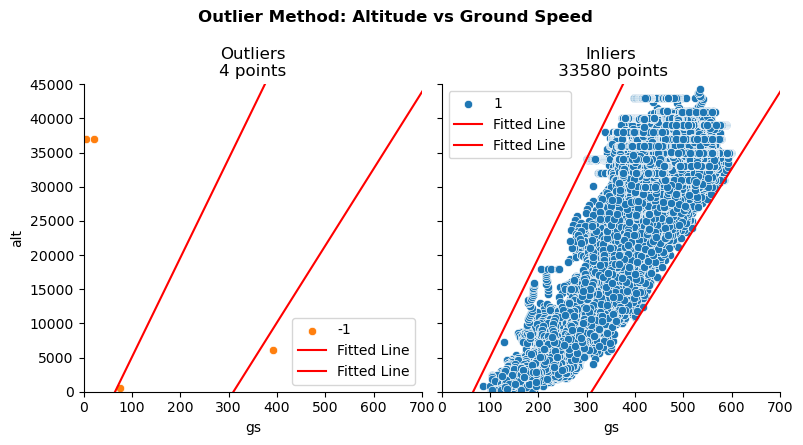

In [244]:
outlier_plot(df,"Altitude vs Ground Speed", "gs","alt",[0,700], [0,45000])

# YDF

In [105]:
import ydf

ydf_IF = ydf.IsolationForestLearner(features=features).train(df)

Train model on 33584 examples
Model trained in 0:00:00.019003


In [32]:
ydf_IF.analyze(df,sampling=0.1)

## Framing and Training